In [1]:
from glob import glob
from gzip import open # NB: overrides standard open()
import os
import math
import functools
import numpy as np
import scipy.interpolate
from scipy import interpolate
import pandas as pd
import pickle as pkl

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

##### Возможно ранее я где-то совершил ошибку при интерполировании сигналов рассеяния, поэтому, пройду весь путь сначала

In [47]:
fds = sorted(os.listdir('C:/Users/admin/Desktop/курсовая 2.0/X — копия/')) 
#формируем список файлов x для считывания в цикле
xw = pd.read_csv('C:/Users/admin/Desktop/курсовая 2.0/X — копия/01.txt',sep='\t')
colums=list(xw.columns.values) #установил имена колонок
rows=list(xw.index.values)  #установил имена строчек

In [48]:
X=np.zeros([35,206,55]) #инициализирую массив нулей

In [49]:
# X = the predictors, a tensor
# dimensions: (sample, emission wavelength, excitation wavelength)

# first read the text files individually
# make sure to sort the list of files, they must correspond to rows in y
X_ = [pd.read_csv(f, sep='\t') for f in sorted(glob('C:/Users/admin/Desktop/курсовая 2.0/X — копия/??.txt'))]
# sanity check: wavelengths must be the same in all files
for x in X_[1:]:
	# errors will also happen if any of the files have different dimensions
	if not ((x.axes[0] == X_[0].axes[0]).all() and (x.axes[1] == X_[0].axes[1]).all()):
		# it doesn't quite matter what we raise here
		# the important thing is to complain loudly and crash
		raise Exception(x.axes)

In [50]:
# Считаем наши данные в наш тензор
for i in range(0,35):
    x = pd.read_csv('C:/Users/admin/Desktop/курсовая 2.0/X — копия/'+fds[i],sep='\t')
    x = x.fillna(0)
    x = x.replace(',','.', regex=True) #меняю ',' на '.'
    x = x.astype(float) #конвертирую из string в float
    X[i,:,:]=np.array(x)

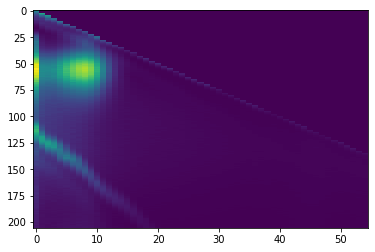

In [51]:
plt.imshow(X[34,:,:],aspect='auto')
plt.show()

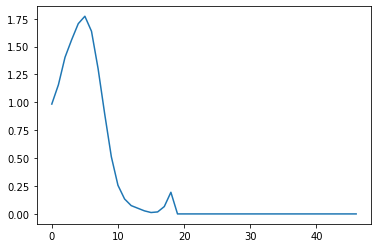

In [52]:
plt.plot(X[34,53,3:50])
plt.show();

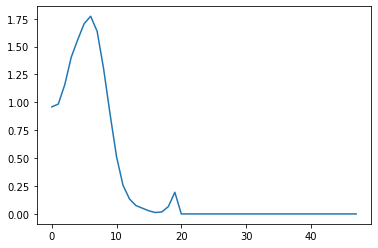

In [53]:
plt.plot(X[34,53,2:50])
plt.show();

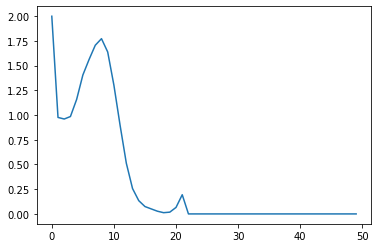

In [54]:
plt.plot(X[34,53,0:50])
plt.show();

#### Как видно из графиков чуть выше, к нашему спектру вначале дабавился ещё и эмиссионный спектр. В прошлый раз я пытался его интерполировать, что бы не терять данные, сейчас просто отрежу первые пару длин волн.

In [55]:
koef=3 #количество столбцов, которые будут отрезаны
X=X[:,:,koef:]

In [56]:
ll=xw.columns.values[koef:] #колонки
lrl=xw.index.values #строчки
lrl=lrl.astype(float)
ll=ll.astype(float)
Xw=np.zeros([len(lrl),len(ll)]) #инициализирую массив нулей
cons=3400
def lo(t):
    return  1/((1/t) - (cons/1e7))
for i in range(0,len(lrl)):
    for j in range(0,len(ll)):
        if (
                (math.fabs((2*ll[j])-(lrl[i]))<15) or 
                (math.fabs(ll[j]-(lrl[i]))<15) or
                (math.fabs((2*lrl[i])-(lo(ll[j])))<15) or 
                (math.fabs(lrl[i]-lo(ll[j]))<15)):
            Xw[i,j]=1.0  #собираю булеву матрицу
Xw=Xw[:,koef:]

##### Как видно из графиков, идея с поиском с использованием аналитического вида прямых рассеяния провалилась, поэтому, перехожу к простому подбору. Разделю каждый входящий вектор на крупные пики (не шум), и Придумаю какой-нибудь простенький классификатор, чтобы их соотнести


In [57]:
def function_3(data,rows,n):
    signal_length = len(rows)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(rows)
    yarr = np.array(data)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

### Стратегия такая. Комбинационное рассеяние буду искать через локальные экстремумы, но пики рассеяния ниже 100-й строчки буду искать при помощи нового метода приближения (functional_3). 

In [58]:
ee,yy=function_3(X[3,:,5],lrl,7)

In [59]:
len(yy)

29

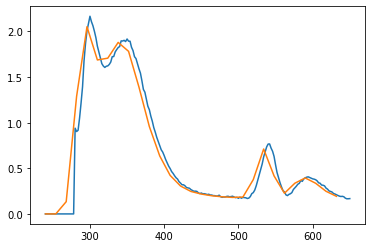

In [60]:
plt.plot(lrl, X[3,:,5])
plt.plot(ee,yy)
plt.show();

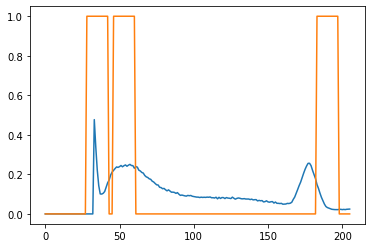

In [61]:
plt.plot(X[3,:,10])
plt.plot(Xw[:,10])
plt.show();

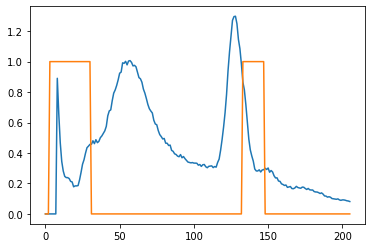

In [62]:
plt.plot(X[3,:,0])
plt.plot(Xw[:,0])
plt.show();

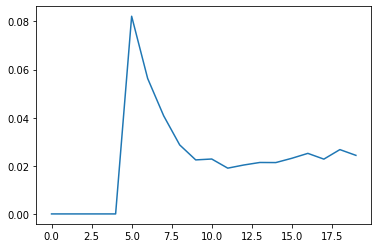

In [63]:
plt.plot(X[3,130:150,51])
#plt.plot(Xw[:,35])
plt.show();

In [64]:
def function_4(data, wave):
    bool_vecror=np.zeros([len(data)])
    for i in range(0,len(data)):
        if data[i]!=0:
            while True:
                if(data[i-1]>data[i]) and (data[i+1]>data[i]) and (data[i+2]>data[i+1]):
                    break
                bool_vecror[i]=1
                i+=1
            break
    wale_len=list()
    intensive=list()
    wale_learn=list()
    j=0
    while True:
        if (bool_vecror[j+1]==1 and bool_vecror[j]==0):
            wale_learn.append(wave[j])
            intensive.append(data[j])
        if (bool_vecror[j]==1):
            while (bool_vecror[j]==1):
                wale_len.append(wave[j])
                j+=1
            for g in range(0,4):
                wale_learn.append(wave[j+g])
                intensive.append(data[j+g])
            break;
        j+=1
    #print(wale_learn)    
    #print()
    #print(intensive)
    #print(wale_len)
    equi=scipy.interpolate.PchipInterpolator(np.array(wale_learn) ,np.array(intensive) )
    new_data=equi(np.array(wale_len)).astype(float)
    cop_data=data.copy()
    for i in range(0,len(wave)):
        for l in range(0,len(wale_len)):
            if (wave[i]==wale_len[l]):
                cop_data[i]=new_data[l]
    return cop_data
            

In [65]:
new_data=np.zeros(X.shape)
for i in range(0,X.shape[0]):
    for j in range(0,X.shape[2]):
        new_data[i,:,j]=function_4(X[i,:,j],lrl)
        

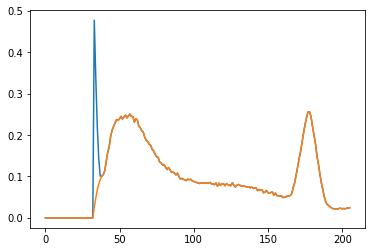

In [66]:
plt.plot(X[3,:,10])
plt.plot(new_data[3,:,10])
plt.show();

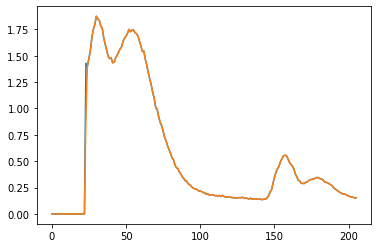

In [71]:
plt.plot(X[3,:,6])
plt.plot(new_data[3,:,6])
plt.show();

#### Как видно из графиков, иногда интерполяционный коридор слишком широкий, а иногда, наоборот, слишком узкий, поэтому, напишу функцию, которая подгоняет эту ширину

In [188]:
def function_1 (data, bool_vector, relation):
    bottom_koef=1.01
    # Я заметил, что на некоторых образцах коридор 1 оказывается настолько широким, что помимо сигнала рассеяния
    # полностью захватывает наш сигнал, поэтому нужно ещё раз пройтись (Смотреть образец №3)
    for i in range(1,len(bool_vector)-1):
        if (bool_vector[i-1]==1) and (bool_vector[i]==1) and (bool_vector[i+1]==1):
            if (bool_vector[i-1]>bottom_koef*bool_vector[i]) and (bool_vector[i+1]>bottom_koef*bool_vector[i]):
                while (bool_vector[i+1]!=0):
                    bool_vector[i]=0
                    i+=1
    for i in range(0,len(bool_vector)-1):
        if data[i]==0:
            bool_vector[i]=0
            continue
        if (bool_vector[i]==1) and (bool_vector[i+1]==0):
            while data[i]<=data[i+1]:
                bool_vector[i]=0
                i-=1
            if ((data[i]/data[i+1])>=relation):
                bool_vector[i+1]=1
        if (bool_vector[i]==0) and (bool_vector[i+1]==1):
            while data[i]>=data[i+1]:
                bool_vector[i+1]=0
                if (i==len(bool_vector)-2):
                    break
                i+=1
    return bool_vector

In [189]:
def function_2 (data, bool_matrix, relation):
    for i in range(0,data.shape[1]):
        for j in range(0,da)
        bool_matrix[:,i]=function_1(data[34,:,i],Xw[:,i],1.01)

SyntaxError: invalid syntax (<ipython-input-189-094ad36b56ea>, line 3)

In [190]:
for i in range(0,32):
    Xw[:,i]=function_1(X[3,:,i],Xw[:,i],1.01)

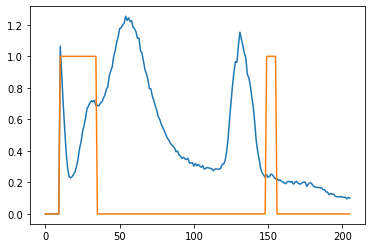

In [191]:
plt.plot(X[3,:,1])
plt.plot(Xw[:,1])
plt.show();

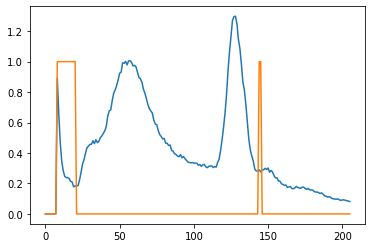

In [192]:
plt.plot(X[3,:,0])
plt.plot(Xw[:,0])
plt.show();

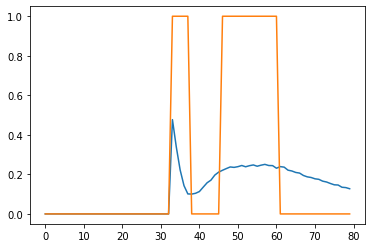

In [193]:
plt.plot(X[3,0:80,10])
plt.plot(Xw[0:80,10])
plt.show();

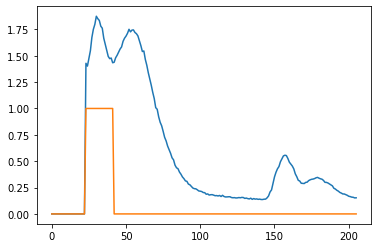

In [276]:
plt.plot(X[3,:,6])
plt.plot(Xw[:,6])
plt.show();

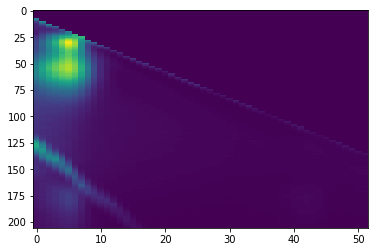

In [196]:
plt.imshow(X[3,:,:],aspect='auto')
plt.show()